## **Basic Liibraries**

In [31]:
# importing basic libraries required
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# suppress display of warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Data Preprocessing and Visualization**

In [20]:
# Set your train_dir path
train_dir = '/kaggle/input/face-recognition-dataset/Original Images/Original Images'

In [21]:
# Using ImageDataGenerator for data augmentation
generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # 10% of the data will be used for validation
)

In [22]:
# Load and split the data into training and validation sets
train_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="training"  # This is for training data
)

Found 2318 images belonging to 31 classes.


In [23]:
val_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="validation"  # This is for validation data
)

Found 244 images belonging to 31 classes.


In [36]:
# Get the list of classes
class_names= list(train_ds.class_indices.keys())
print(classes)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [32]:
# Generate a random integer between 1 and 73 which is the number of batches of image
random_integer = random.randint(1, 73)
train_one_sample = train_ds[random_integer][0] # Selecting a random batch of images
np. asarray(train_one_sample).shape 

(32, 128, 128, 3)

**Note :**

* Each batch is of shape (32,128,128,3) that is each batch contains 32 images of (128,128,3) each 

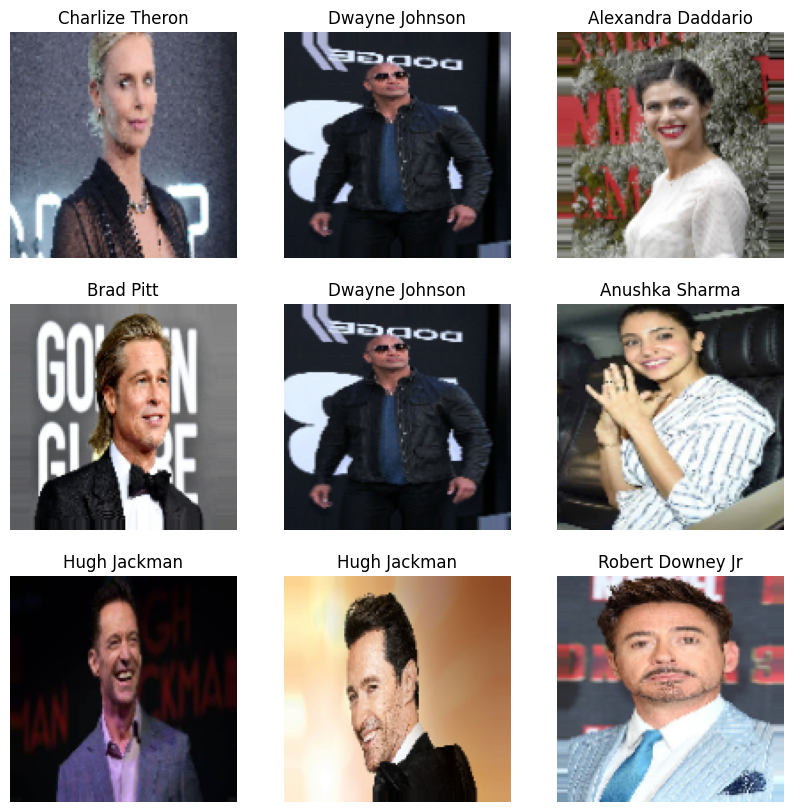

In [37]:
# Visualizing 9 random samples from the given dataset

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the training data
images, labels = next(iter(train_ds))

# Select 9 random images from the batch
random_indices = np.random.randint(0, len(images), size=9)
images = images[random_indices]
labels = labels[random_indices]


# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the images and labels and plot them
for ax, image, label in zip(axes.flat, images, labels):
    ax.imshow(image)
    ax.set_title(class_names[np.argmax(label)])
    ax.axis("off")

# Show the plot
plt.show()

In [49]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

## **Base CNN Model**

In [42]:
# Build the model
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(len(classes),activation='softmax'))

In [43]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"]
)

In [44]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         1,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,343 (1.76 MB)

 Trainable params: 460,255 (1.76 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [45]:
# Train the model using the training set and validate on the validation set
history = model.fit(train_ds, epochs=10, validation_data=val_ds, batch_size=32)

Epoch 1/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 15:14 13s/step - accuracy: 0.0000e+00 - loss: 4.2197

W0000 00:00:1717569251.173896     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.0614 - loss: 3.6166

W0000 00:00:1717569296.201995     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


73/73 ━━━━━━━━━━━━━━━━━━━━ 62s 690ms/step - accuracy: 0.0618 - loss: 3.6122 - val_accuracy: 0.0492 - val_loss: 3.4412
Epoch 2/10


W0000 00:00:1717569300.878619     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 626ms/step - accuracy: 0.1509 - loss: 3.0689 - val_accuracy: 0.0369 - val_loss: 4.0463
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 598ms/step - accuracy: 0.1977 - loss: 2.7512 - val_accuracy: 0.0246 - val_loss: 4.1698
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 619ms/step - accuracy: 0.2581 - loss: 2.4834 - val_accuracy: 0.0574 - val_loss: 3.9544
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 623ms/step - accuracy: 0.3189 - loss: 2.2738 - val_accuracy: 0.1148 - val_loss: 3.2454
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 611ms/step - accuracy: 0.3875 - loss: 2.0717 - val_accuracy: 0.1721 - val_loss: 2.9687
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 82s 613ms/step - accuracy: 0.4109 - loss: 1.9087 - val_accuracy: 0.2049 - val_loss: 3.0538
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 617ms/step - accuracy: 0.4528 - loss: 1.7657 - val_accuracy: 0.2541 - val_loss: 2.5902
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 601ms/step - accuracy: 0.5067 - loss: 1.6019 - val_accuracy: 0.286

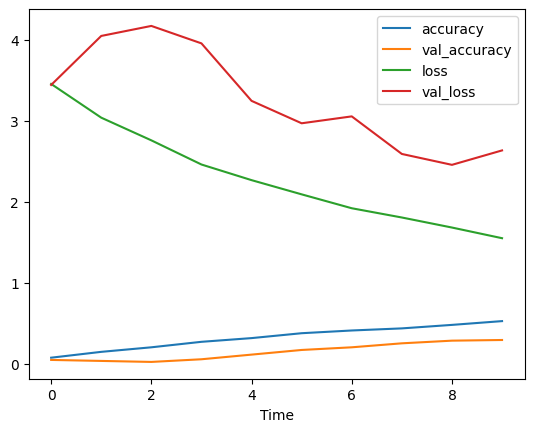

In [46]:
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Time')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [47]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy*100: .2f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 597ms/step - accuracy: 0.4869 - loss: 1.6777
Training Accuracy:  49.31


In [48]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {train_accuracy*100: .2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - accuracy: 0.3031 - loss: 2.5264
Validation Accuracy:  49.31


## **VGG Model**

In [17]:
IMAGE_SIZE = [128, 128]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(31, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │       253,983 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,968,671 (57.10 MB)

 Trainable params: 253,983 (992.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:

BATCH_SIZE = 16
history = model.fit(train_ds, epochs=8, validation_data=val_ds, batch_size=BATCH_SIZE)

Epoch 1/8
 1/73 ━━━━━━━━━━━━━━━━━━━━ 25:28 21s/step - accuracy: 0.0000e+00 - loss: 3.7167

I0000 00:00:1717567156.203767     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717567156.222557     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/73 ━━━━━━━━━━━━━━━━━━━━ 30s 942ms/step - accuracy: 0.0630 - loss: 3.6123

W0000 00:00:1717567193.834949     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.0956 - loss: 3.4262

W0000 00:00:1717567221.162699     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


73/73 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.0973 - loss: 3.4162 - val_accuracy: 0.2336 - val_loss: 2.6773
Epoch 2/8


W0000 00:00:1717567234.993141     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 625ms/step - accuracy: 0.4258 - loss: 2.0328 - val_accuracy: 0.2828 - val_loss: 2.3460
Epoch 3/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 630ms/step - accuracy: 0.5679 - loss: 1.5429 - val_accuracy: 0.3648 - val_loss: 2.1338
Epoch 4/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 614ms/step - accuracy: 0.6670 - loss: 1.2572 - val_accuracy: 0.3689 - val_loss: 2.0638
Epoch 5/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 619ms/step - accuracy: 0.7133 - loss: 1.0481 - val_accuracy: 0.3934 - val_loss: 2.0316
Epoch 6/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 606ms/step - accuracy: 0.7708 - loss: 0.8968 - val_accuracy: 0.4057 - val_loss: 1.9980
Epoch 7/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 620ms/step - accuracy: 0.8202 - loss: 0.7623 - val_accuracy: 0.4344 - val_loss: 1.9673
Epoch 8/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 618ms/step - accuracy: 0.8576 - loss: 0.6484 - val_accuracy: 0.4303 - val_loss: 1.9086


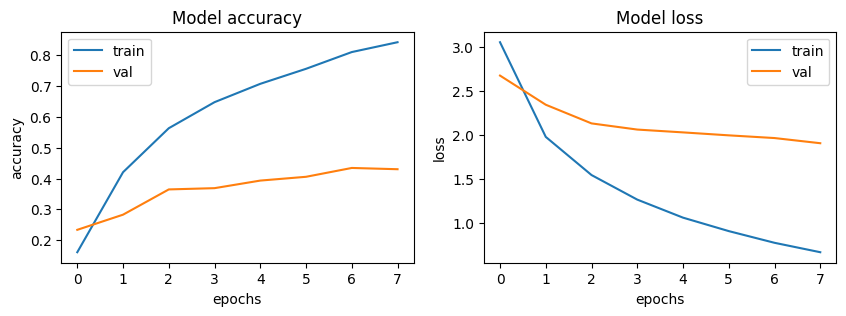

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy*100: .2f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 613ms/step - accuracy: 0.8953 - loss: 0.5351
Training Accuracy:  88.83


W0000 00:00:1717567628.027441     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [13]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {train_accuracy*100: .2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.4249 - loss: 1.9156
Validation Accuracy:  88.83


In [15]:
# Get accuracy on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.3859 - loss: 1.9513
Test Accuracy: 39.75%
